<a href="https://colab.research.google.com/github/rgaguiar/search_biometric/blob/main/extraction_roi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%%capture
# !pip install protobuf==3.20
!pip install -q --upgrade mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 45.7 MB/s eta 0:00:00


In [3]:
import os
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
import csv
import shutil

import mediapipe as mp
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

# Extração do ROI

In [31]:
# Rotina para extrair em grande escala (depois criar uma classe passando apenas o parametro do endereço da imagem)

# def extract_hand_roi(image_path, output_path, mirror=False):
#     """
#     Função para extrair o ROI da impressão palmar a partir de uma imagem de mão usando MediaPipe Hands.

#     Parâmetros:
#     - image_path (str): Caminho para a imagem da mão.
#     - output_path (str): Caminho para salvar a imagem do ROI extraído.
#     - mirror (bool): Se True, espelha a imagem horizontalmente.
#     """
#     img = cv2.imread(str(image_path))

#     if img is None:
#         print(f"Erro ao carregar a imagem: {image_path}")
#         return

#     if mirror:
#         img = cv2.flip(img, 1)

#     mpHands = mp.solutions.hands
#     hands = mpHands.Hands(
#         static_image_mode=True, #  função processa cada imagem de maneira independente
#         max_num_hands=2, # número máximo de mãos a serem detectadas em uma imagem
#         min_detection_confidence=0.1, # confiança mínima exigida para que uma detecção de mão seja considerada válida
#         model_complexity=0 # nível de complexidade do modelo [0, 1 e 2] - model_complexity=0 configura o modelo mais simples, visando eficiência e menor custo computacional.
#     )

#     def coordinate(id, h, w, lm):
#         cx, cy = lm.x * w, lm.y * h
#         return cx, cy

#     imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     results = hands.process(imgRGB)

#     h, w, c = img.shape

#     if results.multi_hand_landmarks:
#         for handLms in results.multi_hand_landmarks:
#             # Posição dos marcos
#             x5, y5 = coordinate(5, h, w, handLms.landmark[5])
#             x9, y9 = coordinate(9, h, w, handLms.landmark[9])
#             x13, y13 = coordinate(13, h, w, handLms.landmark[13])
#             x17, y17 = coordinate(17, h, w, handLms.landmark[17])

#             x_avg_5_9 = (x5 + x9) / 2
#             y_avg_5_9 = (y5 + y9) / 2

#             x_avg_13_17 = (x13 + x17) / 2
#             y_avg_13_17 = (y13 + y17) / 2

#             angle = np.arctan2(y_avg_13_17 - y_avg_5_9, x_avg_13_17 - x_avg_5_9)
#             angle_deg = np.degrees(angle)

#             R = cv2.getRotationMatrix2D((w // 2, h // 2), angle_deg, 1)
#             img_r = cv2.warpAffine(img, R, (w, h))

#             v1 = np.array([x_avg_5_9, y_avg_5_9, 1])
#             v2 = np.array([x_avg_13_17, y_avg_13_17, 1])
#             v1_rot = (R[:, :2] @ v1[:2] + R[:, 2]).astype(int)
#             v2_rot = (R[:, :2] @ v2[:2] + R[:, 2]).astype(int)

#             ux, uy = v1_rot[0], v1_rot[1]
#             lx, ly = v2_rot[0], v2_rot[1] + 3 * (v2_rot[0] - v1_rot[0]) // 3

#             img_c = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
#             img_c = cv2.cvtColor(img_c, cv2.COLOR_GRAY2BGR)
#             cv2.rectangle(img_c, (lx, ly), (ux, uy), (0, 255, 0), 2)

#             x_min = max(int(min(lx, ux)), 0)
#             x_max = min(int(max(lx, ux)), w)
#             y_min = max(int(min(ly, uy)), 0)
#             y_max = min(int(max(ly, uy)), h)

#             roi = img_c[y_min:y_max, x_min:x_max]
#             cv2.imwrite(str(output_path), roi)

#             # Limpeza explícita da memória
#             del img, img_r, img_c, roi, R
#             break
#     else:
#         print(f"Mão não detectada na imagem: {image_path}")

#     # Liberação de recursos
#     hands.close()
#     cv2.destroyAllWindows()

# def process_all_folders_sequentially(input_folders, output_base_path):
#     """
#     Função para processar todas as subpastas de maneira sequencial, uma por vez.

#     Parâmetros:
#     - input_folders (list): Lista de caminhos para as pastas de entrada.
#     - output_base_path (str): Caminho base para salvar os ROIs extraídos.
#     """
#     for input_folder in input_folders:
#         for root, dirs, files in os.walk(input_folder):
#             for file in files:
#                 if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#                     image_path = Path(root) / file
#                     relative_path = Path(root).relative_to(input_folder)
#                     output_folder = output_base_path / relative_path
#                     output_folder.mkdir(parents=True, exist_ok=True)

#                     output_path = output_folder / f'roi_{file}'
#                     mirror = 'R' in os.path.basename(root)  # Verifica se o nome da pasta contém a letra 'R'
#                     extract_hand_roi(image_path, output_path, mirror=mirror)  # Processa uma imagem por vez

#                     # Liberação explícita da memória para cada imagem processada
#                     del image_path, relative_path, output_folder, output_path


def extract_hand_roi(image_path, output_path, mirror=False):
    """
    Função para extrair o ROI da impressão palmar a partir de uma imagem de mão usando MediaPipe Hands.

    Parâmetros:
    - image_path (str): Caminho para a imagem da mão.
    - output_path (str): Caminho para salvar a imagem do ROI extraído.
    - mirror (bool): Se True, espelha a imagem horizontalmente.
    """
    img = cv2.imread(str(image_path))

    if img is None:
        print(f"Erro ao carregar a imagem: {image_path}")
        return

    if mirror:
        img = cv2.flip(img, 1)

    mpHands = mp.solutions.hands
    hands = mpHands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.0,
        model_complexity=0
    )

    def coordinate(id, h, w, lm):
        cx, cy = lm.x * w, lm.y * h
        return cx, cy

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    h, w, c = img.shape

    if results.multi_hand_landmarks:
        for i, handLms in enumerate(results.multi_hand_landmarks): #for handLms in results.multi_hand_landmarks:
            confidence = results.multi_handedness[i].classification[0].score
            print(f"Caminho: {image_path} - Confiança de detecção para a mão {i + 1}: {confidence}")

            # Posição dos marcos
            x5, y5 = coordinate(5, h, w, handLms.landmark[5])
            x9, y9 = coordinate(9, h, w, handLms.landmark[9])
            x13, y13 = coordinate(13, h, w, handLms.landmark[13])
            x17, y17 = coordinate(17, h, w, handLms.landmark[17])

            x_avg_5_9 = (x5 + x9) / 2
            y_avg_5_9 = (y5 + y9) / 2

            x_avg_13_17 = (x13 + x17) / 2
            y_avg_13_17 = (y13 + y17) / 2

            angle = np.arctan2(y_avg_13_17 - y_avg_5_9, x_avg_13_17 - x_avg_5_9)
            angle_deg = np.degrees(angle)

            R = cv2.getRotationMatrix2D((w // 2, h // 2), angle_deg, 1)
            img_r = cv2.warpAffine(img, R, (w, h))

            v1 = np.array([x_avg_5_9, y_avg_5_9, 1])
            v2 = np.array([x_avg_13_17, y_avg_13_17, 1])
            v1_rot = (R[:, :2] @ v1[:2] + R[:, 2]).astype(int)
            v2_rot = (R[:, :2] @ v2[:2] + R[:, 2]).astype(int)

            ux, uy = v1_rot[0], v1_rot[1]
            lx, ly = v2_rot[0], v2_rot[1] + 3 * (v2_rot[0] - v1_rot[0]) // 3

            img_c = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
            img_c = cv2.cvtColor(img_c, cv2.COLOR_GRAY2BGR)

            # Verifica se as coordenadas da ROI estão dentro dos limites da imagem
            x_min = max(int(min(lx, ux)), 0)
            x_max = min(int(max(lx, ux)), w)
            y_min = max(int(min(ly, uy)), 0)
            y_max = min(int(max(ly, uy)), h)

            # Verifica se a ROI é válida
            if x_max <= x_min or y_max <= y_min:
                print(f"ROI inválida para a imagem: {image_path}. Coordenadas: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")
                continue

            roi = img_c[y_min:y_max, x_min:x_max]

            # Verifica se a ROI não está vazia
            if roi.size == 0:
                print(f"ROI vazia para a imagem: {image_path}")
                continue

            # Salva a ROI
            cv2.imwrite(str(output_path), roi)

            # Limpeza explícita da memória
            del img, img_r, img_c, roi, R
            break
    else:
        print(f"Mão não detectada na imagem: {image_path}")

    # Liberação de recursos
    hands.close()
    cv2.destroyAllWindows()

def process_all_folders_sequentially(input_folders, output_base_path):
    """
    Função para processar todas as subpastas de maneira sequencial, uma por vez.

    Parâmetros:
    - input_folders (list): Lista de caminhos para as pastas de entrada.
    - output_base_path (str): Caminho base para salvar os ROIs extraídos.
    """
    for input_folder in input_folders:
        for root, dirs, files in os.walk(input_folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = Path(root) / file
                    relative_path = Path(root).relative_to(input_folder)
                    output_folder = output_base_path / relative_path
                    output_folder.mkdir(parents=True, exist_ok=True)

                    output_path = output_folder / f'roi_{file}'
                    mirror = 'R' in os.path.basename(root)  # Verifica se o nome da pasta contém a letra 'R'
                    extract_hand_roi(image_path, output_path, mirror=mirror)  # Processa uma imagem por vez

                    # Liberação explícita da memória para cada imagem processada
                    del image_path, relative_path, output_folder, output_path

# Lista de pastas principais contendo subpastas com as imagens
input_folders = [
    Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/")
]

# Pasta de saída onde os ROIs serão salvos
output_base_path = Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/ChildPalmDB_1_roi_v3")

# Processar todas as pastas de maneira sequencial
process_all_folders_sequentially(input_folders, output_base_path)

# verificar o nível de confiança individual = 0
# identificar mais de uma mão. Pegar a menor

Caminho: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/2332_R_1661231081863_enroll_9.png - Confiança de detecção para a mão 1: 0.9981572031974792
Caminho: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/2332_R_1661231081863_enroll_0.png - Confiança de detecção para a mão 1: 0.9837889075279236
Caminho: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/2332_R_1661231081863_enroll_7.png - Confiança de detecção para a mão 1: 0.9924348592758179
Caminho: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/2332_R_1661231081863_enroll_18.png - Confiança de detecção para a mão 1: 0.997707188129425
Caminho: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/2332_R_1661231081863_enroll_11.png - Confiança de detecção para a mão 1: 0.999252

# Versão salvando os arquivos e csv

In [ ]:
# Função Original
# Função para extrair e salvar o ROI e mover a imagem original se bem-sucedido
def extract_hand_roi(image_path, output_path, csv_writer, mirror=False, move_successful=True):
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Erro ao carregar a imagem: {image_path}")
        return

    if mirror:
        img = cv2.flip(img, 1)

    mpHands = mp.solutions.hands

    # hands = mpHands.Hands()

    hands = mpHands.Hands(
        static_image_mode=True, #  função processa cada imagem de maneira independente
        max_num_hands=2, # número máximo de mãos a serem detectadas em uma imagem
        min_detection_confidence=0.1, # confiança mínima exigida para que uma detecção de mão seja considerada válida
        model_complexity=0 # nível de complexidade do modelo [0, 1 e 2] - model_complexity=0 configura o modelo mais simples, visando eficiência e menor custo computacional.
        )

    def coordinate(id, h, w, lm):
        cx, cy = lm.x * w, lm.y * h
        return cx, cy

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    h, w, c = img.shape

    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            x5, y5 = coordinate(5, h, w, handLms.landmark[5])
            x9, y9 = coordinate(9, h, w, handLms.landmark[9])
            x13, y13 = coordinate(13, h, w, handLms.landmark[13])
            x17, y17 = coordinate(17, h, w, handLms.landmark[17])

            # Calcular o ponto médio entre 5 e 9
            x_avg_5_9 = (x5 + x9) / 2
            y_avg_5_9 = (y5 + y9) / 2
            cv2.circle(img, (int(x_avg_5_9), int(y_avg_5_9)), 5, (0, 0, 255), cv2.FILLED)

            # Calcular o ponto médio entre 13 e 17
            x_avg_13_17 = (x13 + x17) / 2
            y_avg_13_17 = (y13 + y17) / 2
            cv2.circle(img, (int(x_avg_13_17), int(y_avg_13_17)), 5, (0, 0, 255), cv2.FILLED)

            angle = np.arctan2(y_avg_13_17 - y_avg_5_9, x_avg_13_17 - x_avg_5_9)
            angle_deg = np.degrees(angle)
            R = cv2.getRotationMatrix2D((w // 2, h // 2), angle_deg, 1)
            img_r = cv2.warpAffine(img, R, (w, h))

            v1 = np.array([x_avg_5_9, y_avg_5_9, 1])
            v2 = np.array([x_avg_13_17, y_avg_13_17, 1])
            v1_rot = (R[:, :2] @ v1[:2] + R[:, 2]).astype(int)
            v2_rot = (R[:, :2] @ v2[:2] + R[:, 2]).astype(int)

            ux, uy = v1_rot[0], v1_rot[1]
            lx, ly = v2_rot[0], v2_rot[1] + 3 * (v2_rot[0] - v1_rot[0]) // 3

            x_min = max(int(min(lx, ux)), 0)
            x_max = min(int(max(lx, ux)), w)
            y_min = max(int(min(ly, uy)), 0)
            y_max = min(int(max(ly, uy)), h)

            roi = img_r[y_min:y_max, x_min:x_max]
            # cv2.imwrite(str(output_path), roi)
            cv2.imwrite(str(output_path), img)

            csv_writer.writerow([
                os.path.basename(image_path),
                # x_min, y_min, x_max, y_max
                x_avg_5_9, y_avg_5_9, x_avg_13_17, y_avg_13_17
            ])

            if move_successful:
                destination_folder = output_path.parent / "successful_extractions"
                destination_folder.mkdir(parents=True, exist_ok=True)
                shutil.copy(str(image_path), destination_folder / image_path.name)

            del img, img_r, roi, R
            break
    else:
        print(f"Mão não detectada na imagem: {image_path}")

    hands.close()
    cv2.destroyAllWindows()

# Processamento de pastas e criação do CSV
def process_all_folders_sequentially(input_folders, output_base_path, csv_path):
    with open(csv_path, mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
#       csv_writer.writerow(['filename', 'startX', 'startY', 'endX', 'endY'])
        csv_writer.writerow([None, None, None, None, None])

        for input_folder in input_folders:
            for root, dirs, files in os.walk(input_folder):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = Path(root) / file
                        relative_path = Path(root).relative_to(input_folder)
                        output_folder = output_base_path / relative_path
                        output_folder.mkdir(parents=True, exist_ok=True)

                        output_path = output_folder / f'roi_{file}'
                        mirror = 'R' in file
                        extract_hand_roi(image_path, output_path, csv_writer, mirror=mirror)


# Lista de pastas principais contendo subpastas com as imagens
input_folders = [
   Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/")
    # Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/")
]

# /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/train


# Pasta de saída onde os ROIs serão salvos
output_base_path = Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/ChildPalmDB_1/")
# "/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/train_roi/"
# /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/ChildPalmDB_1/


# Caminho do arquivo CSV para salvar as coordenadas
csv_output_path = "/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/roi_coordinates_all_v6.csv"
# "/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/roi_coordinates_train.csv"


# Processar todas as pastas de maneira sequencial
process_all_folders_sequentially(input_folders, output_base_path, csv_output_path)


Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2348L/2348_L_1661232010438_enroll_6.png
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2348L/2348_L_1661232010438_enroll_3.png
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2371R/2371_R_1661236541298_enroll_15.png
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2371R/2371_R_1661236541298_enroll_16.png
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2424L/2424_L_1661317304421_enroll_11.png


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import shutil
import os
from pathlib import Path
import csv

# Função para extrair e salvar o ROI e mover a imagem original se bem-sucedido
def extract_hand_roi(image_path, output_path, csv_writer, mirror=False, move_successful=True):
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Erro ao carregar a imagem: {image_path}")
        return

    if mirror:
        img = cv2.flip(img, 1)

    mpHands = mp.solutions.hands
    hands = mpHands.Hands()

    def coordinate(id, h, w, lm):
        cx, cy = lm.x * w, lm.y * h
        return cx, cy

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    h, w, c = img.shape

    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            # Extrair as coordenadas de 5 pontos específicos para calcular a região
            x5, y5 = coordinate(5, h, w, handLms.landmark[5])
            x9, y9 = coordinate(9, h, w, handLms.landmark[9])
            x13, y13 = coordinate(13, h, w, handLms.landmark[13])
            x17, y17 = coordinate(17, h, w, handLms.landmark[17])

            # Calcular a média entre os pontos 5-9 e 13-17 para determinar o centro da mão
            x_avg_5_9 = (x5 + x9) / 2
            y_avg_5_9 = (y5 + y9) / 2
            x_avg_13_17 = (x13 + x17) / 2
            y_avg_13_17 = (y13 + y17) / 2

            # Calcular o ângulo da linha que conecta os dois centros
            angle = np.arctan2(y_avg_13_17 - y_avg_5_9, x_avg_13_17 - x_avg_5_9)
            angle_deg = np.degrees(angle)

            # Calcular a matriz de rotação, mas não a aplique ainda
            R = cv2.getRotationMatrix2D((w // 2, h // 2), angle_deg, 1)

            # Coordenadas do ROI antes da rotação (imagem original)
            v1 = np.array([x_avg_5_9, y_avg_5_9, 1])
            v2 = np.array([x_avg_13_17, y_avg_13_17, 1])

            # Coordenadas do ROI na imagem original (não rotacionada)
            ux, uy = v1[0], v1[1]
            lx, ly = v2[0], v2[1] + 3 * (v2[0] - v1[0]) // 3

            # Ajustar para garantir que o ROI está dentro da imagem original
            x_min = max(int(min(lx, ux)), 0)
            x_max = min(int(max(lx, ux)), w)
            y_min = max(int(min(ly, uy)), 0)
            y_max = min(int(max(ly, uy)), h)

            # Extrair o ROI da imagem original
            roi = img[y_min:y_max, x_min:x_max]
            cv2.imwrite(str(output_path), roi)

            # Salvar as coordenadas no arquivo CSV (relativo à imagem original)
            csv_writer.writerow([os.path.basename(image_path), x_min, y_min, x_max, y_max])

            # Mover a imagem original para uma pasta de sucesso, se necessário
            if move_successful:
                destination_folder = output_path.parent / "successful_extractions"
                destination_folder.mkdir(parents=True, exist_ok=True)
                shutil.move(str(image_path), destination_folder / image_path.name)

                # Restaura a imagem para a orientação original após a rotação
                img_restored = cv2.warpAffine(img, R, (w, h))

                # Salva a imagem restaurada
                restored_folder = output_path.parent / "restored_images"
                restored_folder.mkdir(parents=True, exist_ok=True)
                restored_output_path = restored_folder / f'restored_{image_path.name}'
                cv2.imwrite(str(restored_output_path), img_restored)

            break  # Apenas processa a primeira mão detectada
    else:
        print(f"Mão não detectada na imagem: {image_path}")

    hands.close()
    cv2.destroyAllWindows()

# Processamento de pastas e criação do CSV
def process_all_folders_sequentially(input_folders, output_base_path, csv_path):
    with open(csv_path, mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow([None, None, None, None, None])

        for input_folder in input_folders:
            for root, dirs, files in os.walk(input_folder):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = Path(root) / file
                        relative_path = Path(root).relative_to(input_folder)
                        output_folder = output_base_path / relative_path
                        output_folder.mkdir(parents=True, exist_ok=True)

                        output_path = output_folder / f'roi_{file}'
                        mirror = 'R' in file
                        extract_hand_roi(image_path, output_path, csv_writer, mirror=mirror)

# Lista de pastas principais contendo subpastas com as imagens
input_folders = [
    Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/")
]

# Pasta de saída onde os ROIs serão salvos
output_base_path = Path("/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all_roi_v2/")

# Caminho do arquivo CSV para salvar as coordenadas
csv_output_path = "/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/roi_coordinates_all_v2.csv"

# Processar todas as pastas de maneira sequencial
process_all_folders_sequentially(input_folders, output_base_path, csv_output_path)


Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/024_F_R_8.JPG
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/004_S_R_18.JPG
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/026_F_R_6.JPG
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/012_S_R_14.JPG
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/040_F_R_9.JPG
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/005_F_R_8.JPG
Mão não detectada na imagem: /content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dbImagePalmprint/archive/all/038_S_R_10.JPG
Mão não detectada na ima

# Conferência dos Arquivos

In [ ]:
# Função para criar a lista com a contagem dos arquivos por pasta
def count_files_in_subfolders(base_folder):
    data = []

    for root, dirs, files in os.walk(base_folder):
        for subdir in dirs:
            subfolder_path = Path(root) / subdir

            file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(subfolder_path / f)])

            pasta = Path(root).name
            subpasta = subdir
            endereco_completo = str(subfolder_path)
            data.append([pasta, subpasta, file_count, endereco_completo])

    df = pd.DataFrame(data, columns=['Pasta', 'Subpasta', 'Qtde de Arquivos', 'Endereço'])
    return df

input_path_folders = [
    # Caminhos para os arquivos ROI
    "../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_1_roi",
    "../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_2_roi",
    "../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_3_roi",

    # Caminhos para os arquivos de imagens
    "../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1",
    "../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2",
    "../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3"
]

all_dfs = []
for base_folder in input_path_folders:
    df = count_files_in_subfolders(base_folder)
    all_dfs.append(df)

result_df_combined = pd.concat(all_dfs, ignore_index=True)
result_df_combined.reset_index(inplace=True)
result_df_combined.head()


# result_df_combined.to_csv('contagem_arquivos_subpastas_combinadas.csv', index=False)


,index,Pasta,Subpasta,Qtde de Arquivos,Endereço
0,0,v2_ChildPalmDB_1_roi,2332R,19,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_1_roi/2332R
1,1,v2_ChildPalmDB_1_roi,2470R,15,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_1_roi/2470R
2,2,v2_ChildPalmDB_1_roi,2449L,15,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_1_roi/2449L
3,3,v2_ChildPalmDB_1_roi,2348L,20,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_1_roi/2348L
4,4,v2_ChildPalmDB_1_roi,2332L,1,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_rois/v2_ChildPalmDB_1_roi/2332L


In [ ]:
result_df_combined['TipoImg'] = np.where(
    result_df_combined['Pasta'].str[-3:] == 'roi',
    'ROI',
    'IMG')

result_df_pvt = pd.pivot_table(
    result_df_combined,
    index=['index','Subpasta'],
    columns='TipoImg',
    values='Qtde de Arquivos',
    aggfunc='sum')

result_df_pvt = result_df_pvt.groupby(['Subpasta']).agg({'IMG': 'sum', 'ROI': 'sum'}).reset_index()
result_df_pvt.index.name = None

# resultado da combinação do pivoteamento
result_df_pvt = result_df_pvt.merge(
    result_df_combined[result_df_combined['TipoImg'] == 'IMG'][['Subpasta','Endereço']],
    how='left',
    on='Subpasta')

result_df_pvt['Endereço'] = result_df_pvt['Endereço'] + '/'

result_df_pvt.to_csv('/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/contagem_arquivos_subpastas_combinadas_v2.csv', index=False)


In [6]:
# leitura do arquivo csv das imagens
result_df_pvt_v1 = pd.read_csv('/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/contagem_arquivos_subpastas_combinadas.csv')
result_df_pvt_v2 = pd.read_csv('/content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/contagem_arquivos_subpastas_combinadas_v2.csv')

In [7]:
display(result_df_pvt_v1.nsmallest(10, 'ROI'))
display(result_df_pvt_v2.nsmallest(10, 'ROI'))
#sort_values(by='ROI', ascending=True
#nlargest

,Subpasta,IMG,ROI,Endereço
15,2505R,15.0,0.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2505R/
1,2332L,1.0,1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332L/
317,2613R,20.0,1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2613R/
639,2755L,20.0,1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2755L/
67,2524R,15.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2524R/
291,26127R,9.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26127R/
351,26157L,2.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26157L/
352,26157R,2.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26157R/
640,2755R,20.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2755R/
95,2539R,15.0,3.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2539R/


,Subpasta,IMG,ROI,Endereço
1,2332L,1.0,1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332L/
640,2755R,20.0,1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2755R/
67,2524R,15.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2524R/
291,26127R,9.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26127R/
351,26157L,2.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26157L/
352,26157R,2.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26157R/
653,2762L,20.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2762L/
666,2769R,20.0,2.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2769R/
436,2656L,20.0,3.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2656L/
639,2755L,20.0,3.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2755L/


In [8]:
result_df_pvt_v1[["Subpasta", "IMG", "ROI"]].merge(result_df_pvt_v2[["Subpasta", "ROI"]], how="inner", on="Subpasta").to_excel('merge_v1_v2.xlsx', index=False)

In [9]:
roi_v1 = result_df_pvt_v1["ROI"].sum()
img_v1 = result_df_pvt_v1["IMG"].sum()

print(f'Roi extraído das imagens: {roi_v1}')
print(f'Total de imagens analisadas: {img_v1}')
print(f"Percentual de roi's do total de imagens: {round(roi_v1/img_v1,4)}")

Roi extraído das imagens: 12479.0
Total de imagens analisadas: 13706.0
Percentual de roi's do total de imagens: 0.9105


In [10]:
roi_v2 = result_df_pvt_v2["ROI"].sum()
img_v2 = result_df_pvt_v2["IMG"].sum()

print(f'Roi extraído das imagens: {roi_v2}')
print(f'Total de imagens analisadas: {img_v2}')
print(f"Percentual de roi's do total de imagens: {round(roi_v2/img_v2,4)}")

Roi extraído das imagens: 12798.0
Total de imagens analisadas: 13707.0
Percentual de roi's do total de imagens: 0.9337


In [11]:
result_merge = result_df_pvt_v1.merge(result_df_pvt_v2[["Subpasta", "ROI"]], how="inner", on="Subpasta")

In [21]:
result_merge["ROI_DIF"] = result_merge["ROI_y"] - result_merge["ROI_x"]
result_merge = result_merge[['Subpasta', 'IMG', 'ROI_x', 'ROI_y', "ROI_DIF", 'Endereço']]
result_merge = result_merge.sort_values(by='ROI_DIF')
result_merge = result_merge.reset_index()

In [22]:
result_merge[result_merge['ROI_DIF'] < 0]#["ROI_DIF"]

,index,Subpasta,IMG,ROI_x,ROI_y,ROI_DIF,Endereço
0,658,2764R,20.0,19.0,5.0,-14.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2764R/
1,436,2656L,20.0,15.0,3.0,-12.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2656L/
2,373,2624L,20.0,20.0,10.0,-10.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2624L/
3,59,2520R,15.0,15.0,8.0,-7.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2520R/
4,663,2768L,20.0,15.0,8.0,-7.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2768L/
...,...,...,...,...,...,...,...
84,487,2681R,20.0,17.0,16.0,-1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2681R/
85,153,2569L,15.0,15.0,14.0,-1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2569L/
86,290,26127L,20.0,20.0,19.0,-1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/26127L/
87,164,2574R,15.0,15.0,14.0,-1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_2/2574R/


In [24]:
result_merge[result_merge['Subpasta'].str.contains("2332")]

,index,Subpasta,IMG,ROI_x,ROI_y,ROI_DIF,Endereço
69,2,2332R,20.0,20.0,19.0,-1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/
426,1,2332L,1.0,1.0,1.0,0.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332L/


<ipython-input-54-9ca97ddc7f6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_merge["roi_dif"] = result_merge["ROI_y"] - result_merge["ROI_x"]


,Subpasta,IMG,ROI_x,ROI_y,Endereço,roi_dif
0,2325R,19.0,19.0,19.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2325R/,0.0
1,2332L,1.0,1.0,1.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332L/,0.0
2,2332R,20.0,20.0,19.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2332R/,-1.0
3,2348L,20.0,18.0,20.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2348L/,2.0
4,2348R,19.0,19.0,19.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_1/2348R/,0.0
...,...,...,...,...,...,...
723,2798L,20.0,20.0,20.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2798L/,0.0
724,2798R,20.0,20.0,20.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2798R/,0.0
725,2799L,20.0,20.0,20.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2799L/,0.0
726,2799R,20.0,20.0,20.0,../content/drive/MyDrive/003.Mestrado_UFU/projeto_pesquisa_palmprint/dados_pesquisa/ChildPalmDB_3/2799R/,0.0


['2332_R_1661231081863_enroll_9.png', '2332_R_1661231081863_enroll_0.png', '2332_R_1661231081863_enroll_7.png', '2332_R_1661231081863_enroll_18.png', '2332_R_1661231081863_enroll_11.png', '2332_R_1661231081863_enroll_16.png', '2332_R_1661231081863_enroll_17.png', '2332_R_1661231081863_enroll_10.png', '2332_R_1661231081863_enroll_19.png', '2332_R_1661231081863_enroll_6.png', '2332_R_1661231081863_enroll_1.png', '2332_R_1661231081863_enroll_8.png', '2332_R_1661231081863_enroll_13.png', '2332_R_1661231081863_enroll_14.png', '2332_R_1661231081863_enroll_2.png', '2332_R_1661231081863_enroll_5.png', '2332_R_1661231081863_enroll_4.png', '2332_R_1661231081863_enroll_3.png', '2332_R_1661231081863_enroll_15.png', '2332_R_1661231081863_enroll_12.png']


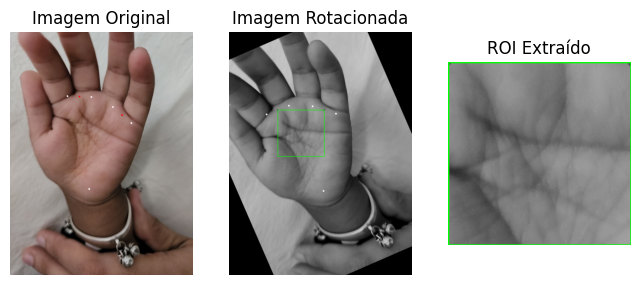

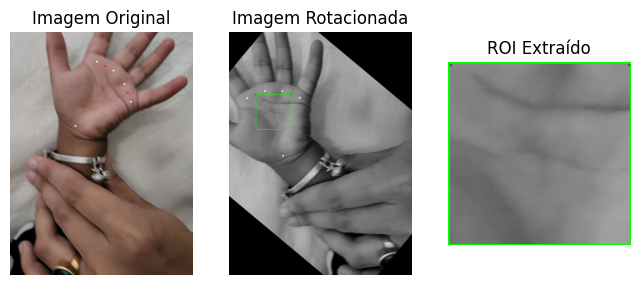

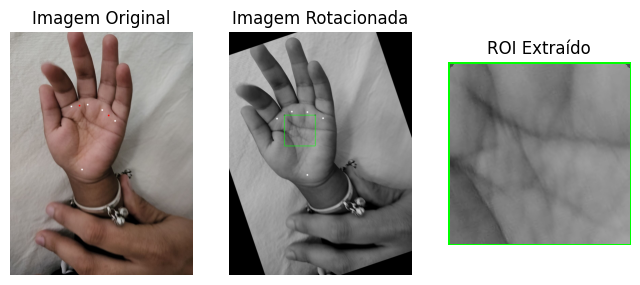

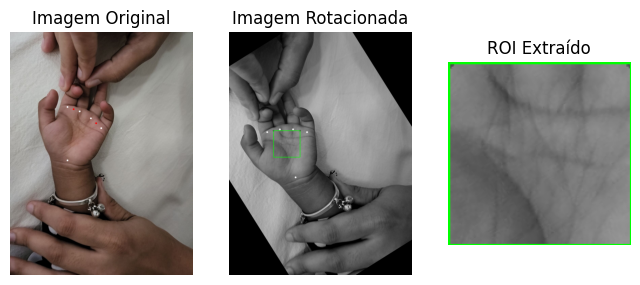

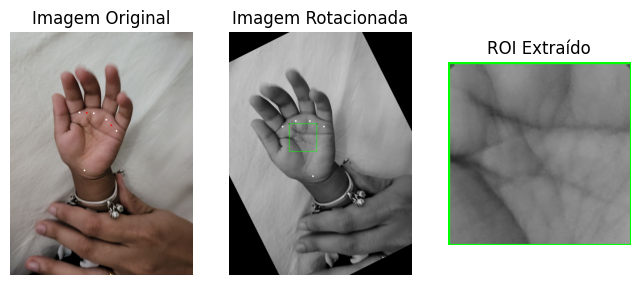

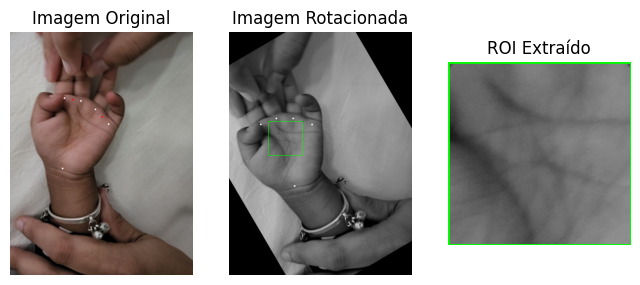

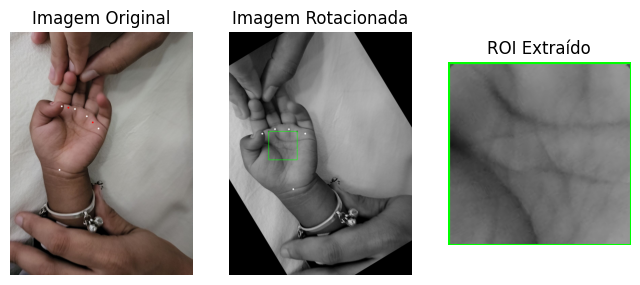

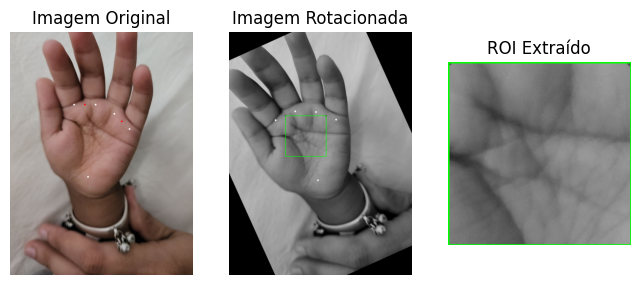

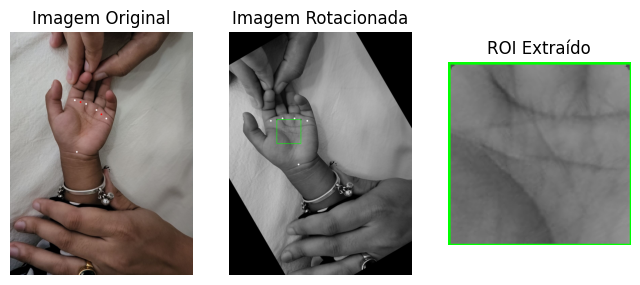

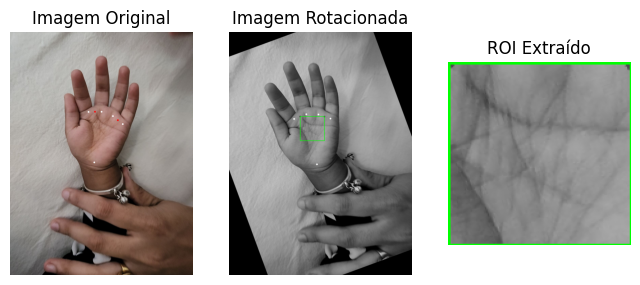

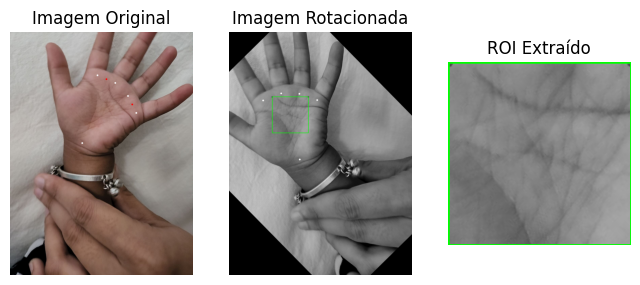

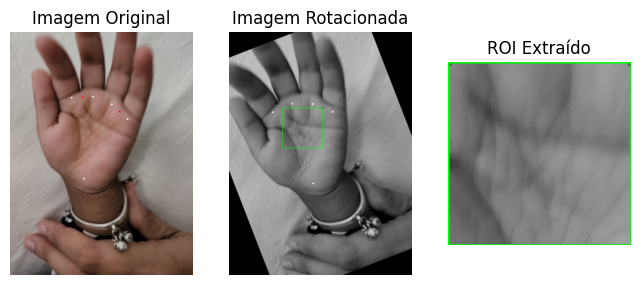

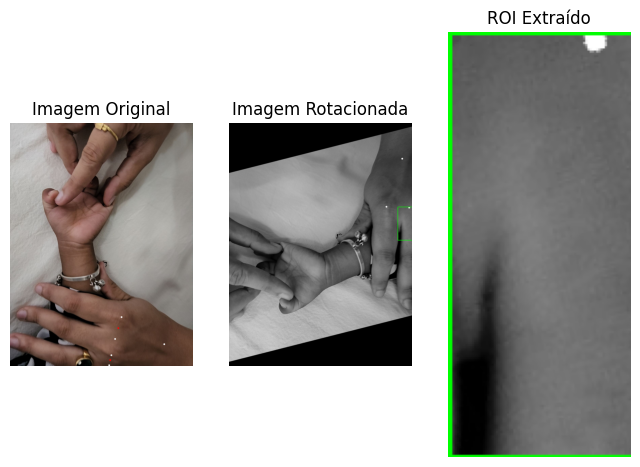

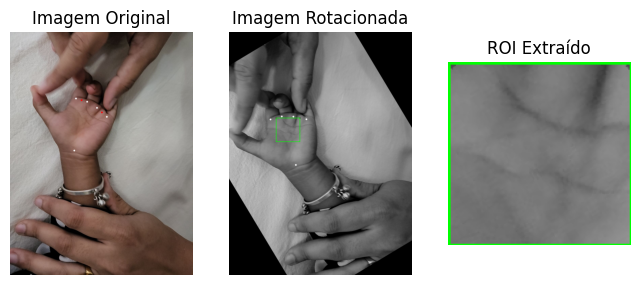

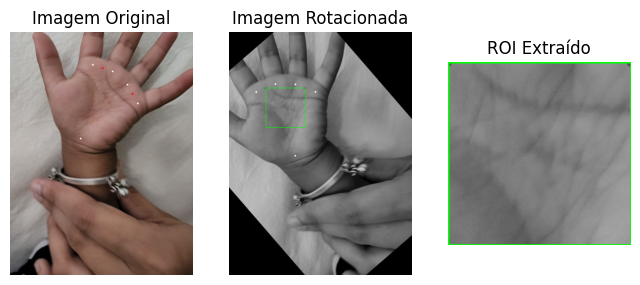

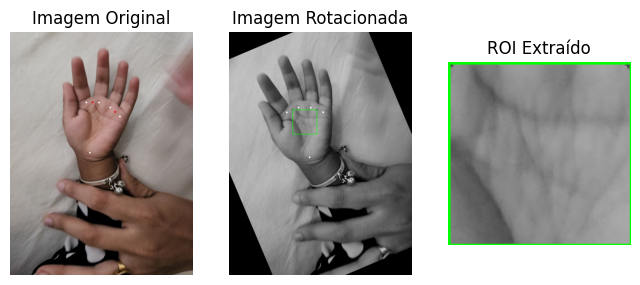

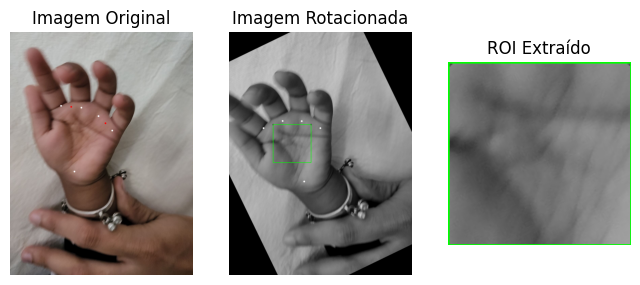

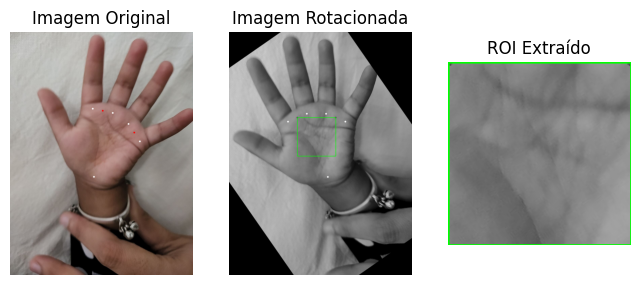

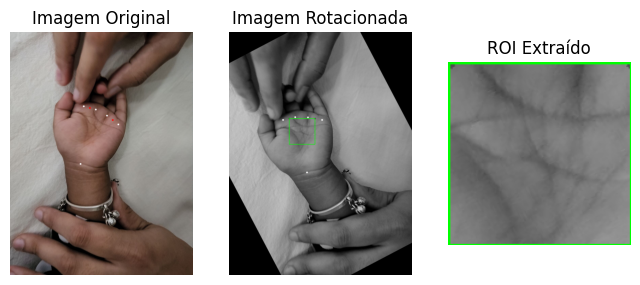

Mão não detectada na imagem.


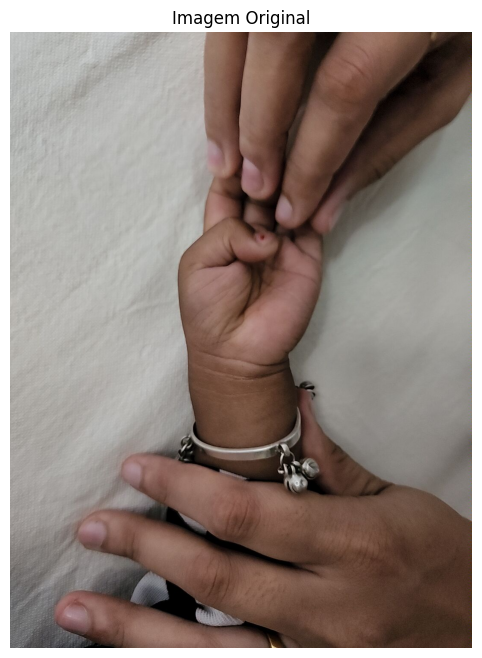

In [26]:
# set imagem específica

select_index = 2
path_img = result_df_pvt_v2.iloc[select_index, 3]

# Função para extrair ROI e espelhar a imagem se necessário
def extract_hand_roi(image_path):
    """
    Função para extrair o ROI da impressão palmar a partir de uma imagem de mão usando MediaPipe Hands.

    Parâmetros:
    - image_path (str): Caminho para a imagem da mão.

    Retorna:
    - ROI extraído da mão (imagem recortada).
    """

    # Carregar a imagem
    img = cv2.imread(image_path)

    # Verificar se o nome do arquivo termina com "R" e espelhar a imagem se necessário
    if 'R' in os.path.basename(image_path):
        img = cv2.flip(img, 1)  # Espelhar horizontalmente

    # Inicializar MediaPipe Hands
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.1,
        model_complexity=0)

    def coordinate(id, h, w, lm):
        cx, cy = lm.x * w, lm.y * h
        # Desenhar o ponto na imagem
        cv2.circle(img, (int(cx), int(cy)), 5, (255, 255, 255), cv2.FILLED)
        return cx, cy

    # Processar a imagem carregada
    if img is not None:
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)

        h, w, c = img.shape

        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                # Obter coordenadas dos marcos 0, 5, 9, 13, 17
                x0, y0 = coordinate(0, h, w, handLms.landmark[0])
                x5, y5 = coordinate(5, h, w, handLms.landmark[5])
                x9, y9 = coordinate(9, h, w, handLms.landmark[9])
                x13, y13 = coordinate(13, h, w, handLms.landmark[13])
                x17, y17 = coordinate(17, h, w, handLms.landmark[17])

                # Calcular o ponto médio entre 5 e 9
                x_avg_5_9 = (x5 + x9) / 2
                y_avg_5_9 = (y5 + y9) / 2
                cv2.circle(img, (int(x_avg_5_9), int(y_avg_5_9)), 5, (0, 0, 255), cv2.FILLED)

                # Calcular o ponto médio entre 13 e 17
                x_avg_13_17 = (x13 + x17) / 2
                y_avg_13_17 = (y13 + y17) / 2
                cv2.circle(img, (int(x_avg_13_17), int(y_avg_13_17)), 5, (0, 0, 255), cv2.FILLED)

                angle = np.arctan2(y_avg_13_17 - y_avg_5_9, x_avg_13_17 - x_avg_5_9)
                angle_deg = np.degrees(angle)

                R = cv2.getRotationMatrix2D((w // 2, h // 2), angle_deg, 1)

                img_r = cv2.warpAffine(img, R, (w, h))

                # Ajustar os pontos após a rotação
                v1 = np.array([x_avg_5_9, y_avg_5_9, 1])
                v2 = np.array([x_avg_13_17, y_avg_13_17, 1])
                v1_rot = (R[:, :2] @ v1[:2] + R[:, 2]).astype(int)
                v2_rot = (R[:, :2] @ v2[:2] + R[:, 2]).astype(int)

                # Calcular a nova posição dos vértices do quadrado após a rotação
                ux = v1_rot[0]
                uy = v1_rot[1] + 0 * (v2_rot - v1_rot)[0] // 3
                lx = v2_rot[0]
                ly = v2_rot[1] + 3 * (v2_rot - v1_rot)[0] // 3

                img_c = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
                img_c = cv2.cvtColor(img_c, cv2.COLOR_GRAY2BGR)
                cv2.rectangle(img_c, (lx, ly), (ux, uy), (0, 255, 0), 2)

                # Encontrar os limites do ROI na imagem rotacionada
                x_min = int(min(lx, ux))
                x_max = int(max(lx, ux))
                y_min = int(min(ly, uy))
                y_max = int(max(ly, uy))

                # Garantir que os limites não ultrapassem os limites da imagem
                x_min = max(x_min, 0)
                x_max = min(x_max, w)
                y_min = max(y_min, 0)
                y_max = min(y_max, h)

                # Extrair o ROI retangular da imagem rotacionada
                roi = img_c[y_min:y_max, x_min:x_max]

                # Exibir as imagens e o ROI extraído
                plt.figure(figsize=[8, 8])
                plt.subplot(131)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title("Imagem Original")
                plt.axis('off')

                plt.subplot(132)
                plt.imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
                plt.title("Imagem Rotacionada")
                plt.axis('off')

                plt.subplot(133)
                plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
                plt.title("ROI Extraído")
                plt.axis('off')
                plt.show()

                cv2.imwrite('output_roi.png', roi)

                return None
        else:

            plt.figure(figsize=[8, 8])
            plt.subplot(111)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Imagem Original")
            plt.axis('off')
            print("Mão não detectada na imagem.")
            return None
    else:
        print("Erro ao carregar a imagem.")
        return None

# Função para listar arquivos no diretório
def list_files_in_directory(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

file_list = list_files_in_directory(path_img)
print(file_list)

# Processar as imagens no diretório
for file_name in file_list:
    file_path = os.path.join(path_img, file_name)

    # Chama a função para extrair o ROI da imagem e espelhar se necessário
    extract_hand_roi(file_path)

In [ ]:
df_merge = result_df_palm.merge(result_df_roi[['Subpasta', 'Qtde de Arquivos']], on='Subpasta', how='left')
df_merge.rename(columns={'Qtde de Arquivos_x':'QtdeImg', 'Qtde de Arquivos_y':'QtdeImgRoi'}, inplace=True)

df_merge['PercSucess'] = (df_merge['QtdeImgRoi'] / df_merge['QtdeImg']).round(3)

df_merge

,Pasta,Subpasta,QtdeImg,QtdeImgRoi,PercSucess
0,ChildPalmDB_1,2332R,20,20,1.0
1,ChildPalmDB_1,2470R,15,15,1.0
2,ChildPalmDB_1,2449L,15,15,1.0
3,ChildPalmDB_1,2348L,20,18,0.9
4,ChildPalmDB_1,2332L,1,1,1.0
...,...,...,...,...,...
723,ChildPalmDB_3,26141L,20,20,1.0
724,ChildPalmDB_3,26102R,20,18,0.9
725,ChildPalmDB_3,26118L,20,20,1.0
726,ChildPalmDB_3,2741R,20,18,0.9


In [ ]:
df_merge.sort_values(by='QtdeImgRoi', ascending=False)

,Pasta,Subpasta,QtdeImg,QtdeImgRoi,PercSucess
614,ChildPalmDB_3,26107L,60,59,0.983
543,ChildPalmDB_3,26143R,40,40,1.000
668,ChildPalmDB_3,2696R,40,40,1.000
699,ChildPalmDB_3,26146L,40,40,1.000
418,ChildPalmDB_3,26106R,40,39,0.975
...,...,...,...,...,...
321,ChildPalmDB_3,26157L,2,2,1.000
514,ChildPalmDB_3,2755L,20,1,0.050
312,ChildPalmDB_2,2613R,20,1,0.050
4,ChildPalmDB_1,2332L,1,1,1.000


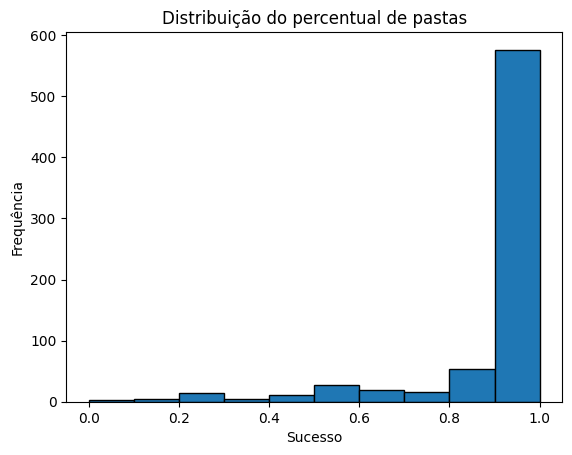

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_merge['PercSucess'] , bins=10  ,edgecolor='black')

plt.xlabel('Sucesso')
plt.ylabel('Frequência')
plt.title('Distribuição do percentual de pastas')
plt.show()


In [ ]:
print('Total de Imagens: ' , df_merge['QtdeImg'].sum())
print('Total de Imagens Processadas: ' , df_merge['QtdeImgRoi'].sum())
print('Total de Imagens Processadas: ' , df_merge['QtdeImgRoi'].sum())

print('Sucesso %: ', (df_merge['QtdeImgRoi'].sum()/df_merge['QtdeImg'].sum()).round(2))

Total de Imagens:  13706
Total de Imagens Processadas:  12479
Sucesso %:  0.91


In [ ]:
df_merge.to_csv('contagem_arquivos_img.csv', index=False)

# Testando o arquivo

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

def extract_hand_roi(image_path):
    """
    Função para extrair o ROI da impressão palmar a partir de uma imagem de mão usando MediaPipe Hands.

    Parâmetros:
    - image_path (str): Caminho para a imagem da mão.

    Retorna:
    - ROI extraído da mão (imagem recortada).
    """

    # Carregar a imagem
    img = cv2.imread(image_path)

    # Inicializar MediaPipe Hands
    mpHands = mp.solutions.hands
    hands = mpHands.Hands()

    def coordinate(id, h, w, lm):
        cx, cy = lm.x * w, lm.y * h
        # Desenhar o ponto na imagem
        cv2.circle(img, (int(cx), int(cy)), 5, (255, 255, 255), cv2.FILLED)
        return cx, cy

    # Processar a imagem carregada
    if img is not None:
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)

        h, w, c = img.shape

        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                # Obter coordenadas dos marcos 5, 9, 13, 17
                x5, y5 = coordinate(5, h, w, handLms.landmark[5])
                x9, y9 = coordinate(9, h, w, handLms.landmark[9])
                x13, y13 = coordinate(13, h, w, handLms.landmark[13])
                x17, y17 = coordinate(17, h, w, handLms.landmark[17])

                # Calcular o ponto médio entre 5 e 9
                x_avg_5_9 = (x5 + x9) / 2
                y_avg_5_9 = (y5 + y9) / 2
                cv2.circle(img, (int(x_avg_5_9), int(y_avg_5_9)), 5, (0, 0, 255), cv2.FILLED)

                # Calcular o ponto médio entre 13 e 17
                x_avg_13_17 = (x13 + x17) / 2
                y_avg_13_17 = (y13 + y17) / 2
                cv2.circle(img, (int(x_avg_13_17), int(y_avg_13_17)), 5, (0, 0, 255), cv2.FILLED)

                angle = np.arctan2(y_avg_13_17 - y_avg_5_9, x_avg_13_17 - x_avg_5_9)
                angle_deg = np.degrees(angle)

                R = cv2.getRotationMatrix2D((w // 2, h // 2), angle_deg, 1)

                img_r = cv2.warpAffine(img, R, (w, h))


                # Ajustar os pontos após a rotação
                v1 = np.array([x_avg_5_9, y_avg_5_9, 1])
                v2 = np.array([x_avg_13_17, y_avg_13_17, 1])
                v1_rot = (R[:, :2] @ v1[:2] + R[:, 2]).astype(int)
                v2_rot = (R[:, :2] @ v2[:2] + R[:, 2]).astype(int)

                # Calcular a nova posição dos vértices do quadrado após a rotação
                ux = v1_rot[0]
                uy = v1_rot[1] + 0 * (v2_rot - v1_rot)[0] // 3
                lx = v2_rot[0]
                ly = v2_rot[1] + 3 * (v2_rot - v1_rot)[0] // 3


                img_c = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
                img_c = cv2.cvtColor(img_c, cv2.COLOR_GRAY2BGR)
                cv2.rectangle(img_c, (lx, ly), (ux, uy), (0, 255, 0), 2)


                # Encontrar os limites do ROI na imagem rotacionada
                x_min = int(min(lx, ux))
                x_max = int(max(lx, ux))
                y_min = int(min(ly, uy))
                y_max = int(max(ly, uy))

                # Garantir que os limites não ultrapassem os limites da imagem
                x_min = max(x_min, 0)
                x_max = min(x_max, w)
                y_min = max(y_min, 0)
                y_max = min(y_max, h)

                # Extrair o ROI retangular da imagem rotacionada
                roi = img_c[y_min:y_max, x_min:x_max]


                # Exibir a imagem original com o retângulo desenhado
                plt.figure(figsize=[8, 8])
                plt.subplot(131)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title("Imagem Original")
                plt.axis('off')

                # Exibir a imagem rotacionada com o retângulo desenhado
                plt.subplot(132)
                plt.imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
                plt.title("Imagem Rotacionada")
                plt.axis('off')
                #plt.show()

                # Exibir o ROI extraído
                plt.subplot(133)
                #plt.figure(figsize=[6, 6])
                plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
                plt.title("ROI Extraído")
                plt.axis('off')
                plt.show()

                cv2.imwrite('output_roi.png', roi)

                return None

        else:
            print("Mão não detectada na imagem.")
            plt.figure(figsize=[8, 8])
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Imagem Original")
            plt.axis('off')

            return None

    else:
        print("Erro ao carregar a imagem.")
        return None

path2 = './ChildPalmDB_1/2424L/2424_L_1661317304421_enroll_0.png'
# path3 = './ChildPalmDB_1/2424L/2424_L_1661317304421_enroll_11.png'
extract_hand_roi(path2)

In [ ]:
import pandas as pd

# Exemplo de dados - pode alterar o data para o arquivo csv (data = pd.read_csv('nome do arquivo.csv'))
data = {
    'Sku': ['Prod1', 'Prod1', 'Prod1', 'Prod1', 'Prod2', 'Prod2', 'Prod2', 'Prod3', 'Prod3', 'Prod3', 'Prod3'],
    'Data': ['01/01/2024', '02/01/2024', '10/01/2024', '22/01/2024', '03/01/2024', '15/01/2024', '17/01/2024', '05/01/2024', '06/01/2024', '10/01/2024', '15/01/2024']
}

df = pd.DataFrame(data)

# Converter a coluna 'Data' para o formato de data
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Criar a coluna descolada por SKU usando o groupby em conjunto com o shift
df['data_aux'] = df.groupby('Sku')['Data'].shift(1)


df.head(15)

,Sku,Data,data_aux
0,Prod1,2024-01-01,NaT
1,Prod1,2024-01-02,2024-01-01
2,Prod1,2024-01-10,2024-01-02
3,Prod1,2024-01-22,2024-01-10
4,Prod2,2024-01-03,NaT
5,Prod2,2024-01-15,2024-01-03
6,Prod2,2024-01-17,2024-01-15
7,Prod3,2024-01-05,NaT
8,Prod3,2024-01-06,2024-01-05
9,Prod3,2024-01-10,2024-01-06


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)

detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("depositphotos_96503350-stock-photo-two-open-empty-hands.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

RuntimeError: Unable to open file at /content/hand_landmarker.task